In [30]:
import numpy as np
import numpy.ma as ma

from astropy.table import Table
import astropy.constants as const

import sys
sys.path.insert(1, "/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/")
from DRP_rotation_curve import extract_data
from Pipe3D_vel_map import extract_Pipe3D_data
from DRP_vel_map_functions import find_vel_bounds
from dark_matter_mass_v1 import rot_fit_BB

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/'
#MANGA_FOLDER = '/home/kelly/Documents/Data/SDSS/'

DRP_FOLDER = MANGA_FOLDER + 'dr16/manga/spectro/analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'
PIPE3D_FOLDER = MANGA_FOLDER + 'dr15/manga/spectro/pipe3d/v2_4_3/2.4.3/'

In [3]:
best_fit_file = '../spirals/DRP-master_file_vflag_BB_smooth1p85_mapFit_N2O2_HIdr2_morph_noWords_v6.txt'

best_fit_parameters = Table.read(best_fit_file, format='ascii.commented_header')

# Single galaxy

In [4]:
gal_ID = '8440-12704'

manga_plate, manga_IFU = gal_ID.split('-')

In [5]:
gal_fit_params_boolean = (best_fit_parameters['MaNGA_plate'] == int(manga_plate)) & (best_fit_parameters['MaNGA_IFU'] == int(manga_IFU))

gal_fit_params = best_fit_parameters[gal_fit_params_boolean]

In [39]:
DRPmaps = extract_data(DRP_FOLDER, gal_ID, ['Ha_vel', 'r_band', 'star_vel'])
P3Dmaps = extract_Pipe3D_data(PIPE3D_FOLDER, gal_ID, ['star_vel', 'Ha_vel', 'v_band'])

v_sys = gal_fit_params['NSA_redshift']*const.c.to('km/s')

mStar_vel_P3D = ma.array(P3Dmaps['star_vel'] - v_sys.value, 
                         mask=((P3Dmaps['star_vel_err'] > 25) | np.isnan(P3Dmaps['star_vel']) | (P3Dmaps['star_vel'] == 0)))
mStar_vel_DRP = ma.array(DRPmaps['star_vel'], mask=DRPmaps['star_vel_mask'])

mr_band = ma.array(DRPmaps['r_band'], mask=DRPmaps['Ha_vel_mask'])
mV_band = ma.array(P3Dmaps['v_band'], mask=mStar_vel_P3D.mask)

mHa_vel_P3D = ma.array(P3Dmaps['Ha_vel'] - v_sys.value, 
                       mask=(np.isnan(P3Dmaps['Ha_vel']) | (P3Dmaps['Ha_vel'] == 0)))
mHa_vel_DRP = ma.array(DRPmaps['Ha_vel'], mask=DRPmaps['Ha_vel_mask'])

mHa_vel_ivar_P3D = ma.array(1/P3Dmaps['Ha_vel_err']**2, mask=mHa_vel_P3D.mask)
mHa_vel_ivar_DRP = ma.array(DRPmaps['Ha_vel_ivar'], mask=DRPmaps['Ha_vel_mask'])

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_28530/1528766888.py:17: RuntimeWarning: divide by zero encountered in true_divide
  mHa_vel_ivar_P3D = ma.array(1/P3Dmaps['Ha_vel_err']**2, mask=mHa_vel_P3D.mask)


### Update the H$\alpha$ velocity maps to exclude those velocities which are not continuous with the main velocity field

In [37]:
DRP_min_vel, DRP_max_vel, DRP_continuous_mask = find_vel_bounds(mHa_vel_DRP, gal_ID)
P3D_min_vel, P3D_max_vel, P3D_continuous_mask = find_vel_bounds(mHa_vel_P3D, gal_ID)

mHa_vel_DRP_continuous = ma.array(DRPmaps['Ha_vel'], mask=DRP_continuous_mask)
mHa_vel_P3D_continuous = ma.array(P3Dmaps['Ha_vel'] - v_sys.value, mask=P3D_continuous_mask)

## Velocity maps

<IPython.core.display.Javascript object>


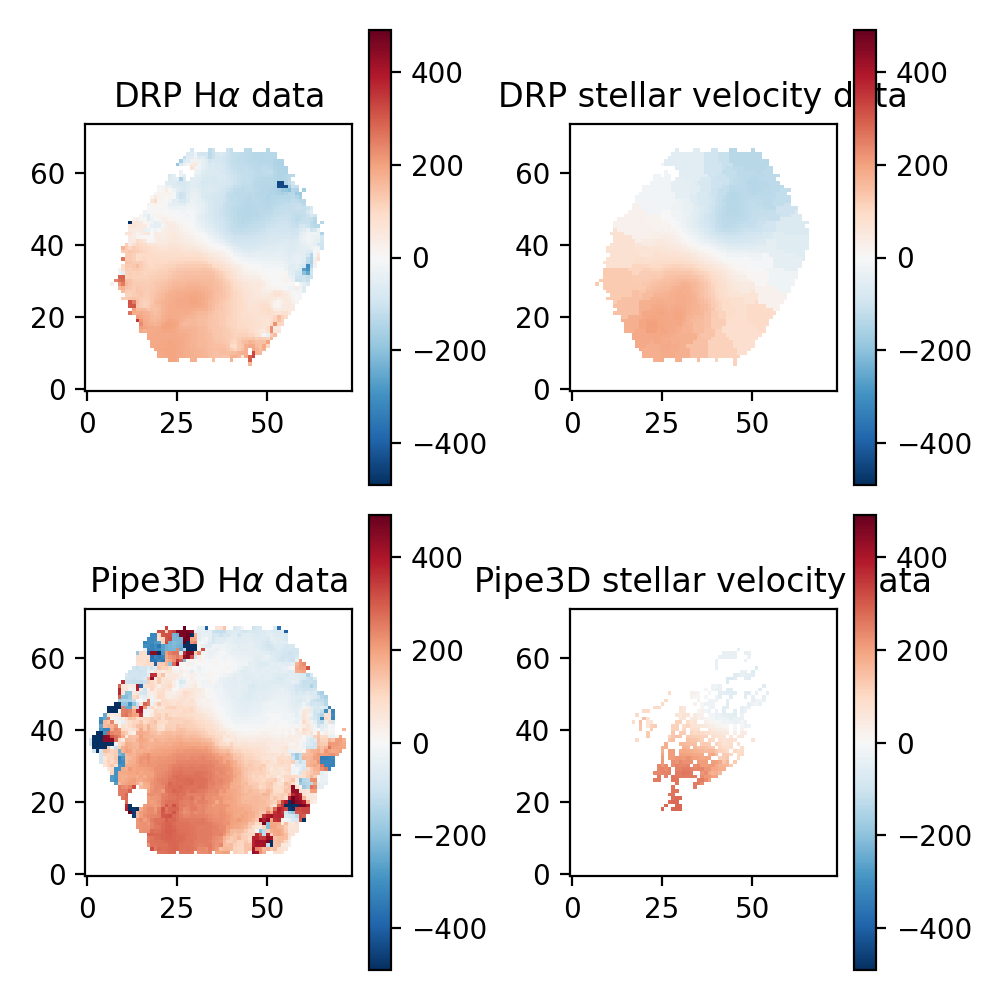

In [40]:
v_extreme = np.max([ma.max(ma.abs(mHa_vel_DRP_continuous)), 
                    ma.max(ma.abs(mHa_vel_P3D_continuous))])

plt.figure(figsize=(5,5), tight_layout=True)

plt.subplot(221)
plt.imshow(mHa_vel_DRP, 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-v_extreme, 
           vmax=v_extreme)
plt.title(r'DRP H$\alpha$ data')
plt.colorbar()

plt.subplot(222)
plt.imshow(mStar_vel_DRP, 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-v_extreme, 
           vmax=v_extreme)
plt.title('DRP stellar velocity data')
plt.colorbar()

plt.subplot(223)
plt.imshow(mHa_vel_P3D, 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-v_extreme, 
           vmax=v_extreme)
plt.title(r'Pipe3D H$\alpha$ data')
plt.colorbar()

plt.subplot(224)
plt.imshow(mStar_vel_P3D, 
           origin='lower', 
           cmap='RdBu_r', 
           vmin=-v_extreme, 
           vmax=v_extreme)
plt.title('Pipe3D stellar velocity data')
plt.colorbar();

# DRP H$\alpha$ velocity v. Pipe3D stellar velocity

In [21]:
fit_results_filename = '../spirals/Pipe3D_starVel_map_results_BB_v1.fits'

fits = Table.read(P3Dstar_filename, format='fits')

In [31]:
################################################################################
# Calculate the velocity at R90, Rmax
#-------------------------------------------------------------------------------
# Convert r from arcsec to kpc
#-------------------------------------------------------------------------------
H0 = 100

dist_to_galaxy_Mpc = (const.c.to('km/s')*fits['NSA_redshift']/H0).value
dist_to_galaxy_kpc = dist_to_galaxy_Mpc*1000

fits['R90_kpc'] = dist_to_galaxy_kpc*np.tan(fits['NSA_elpetro_th90']*(1./60)*(1./60)*(np.pi/180))
#-------------------------------------------------------------------------------

fits['V90_kms'] = rot_fit_BB(fits['R90_kpc'], 
                             [fits['Vmax_map'], 
                              fits['Rturn_map'], 
                              fits['alpha_map']])
################################################################################


fits['M90_Mdisk_ratio'] = 10**(fits['M90_map'] - fits['M90_disk_map'])


bad_boolean = np.logical_or.reduce([np.isnan(fits['M90_map']), 
                                    np.isnan(fits['M90_disk_map']), 
                                    fits['alpha_map'] > 99, 
                                    fits['ba_map'] > 0.998, 
                                    fits['V90_kms']/fits['Vmax_map'] < 0.9, 
                                    (fits['Tidal'] & (fits['DL_merge'] > 0.97)), 
                                    fits['map_frac_unmasked'] < 0.05, 
                                    (fits['map_frac_unmasked'] > 0.13) & (fits['DRP_map_smoothness'] > 1.96), 
                                    (fits['map_frac_unmasked'] > 0.07) & (fits['DRP_map_smoothness'] > 2.9), 
                                    (fits['map_frac_unmasked'] > -0.0638*fits['DRP_map_smoothness'] + 0.255) & (fits['DRP_map_smoothness'] > 1.96), 
                                    fits['M90_Mdisk_ratio'] > 1050])

good_galaxies = fits[~bad_boolean]

/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:6846: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


<IPython.core.display.Javascript object>


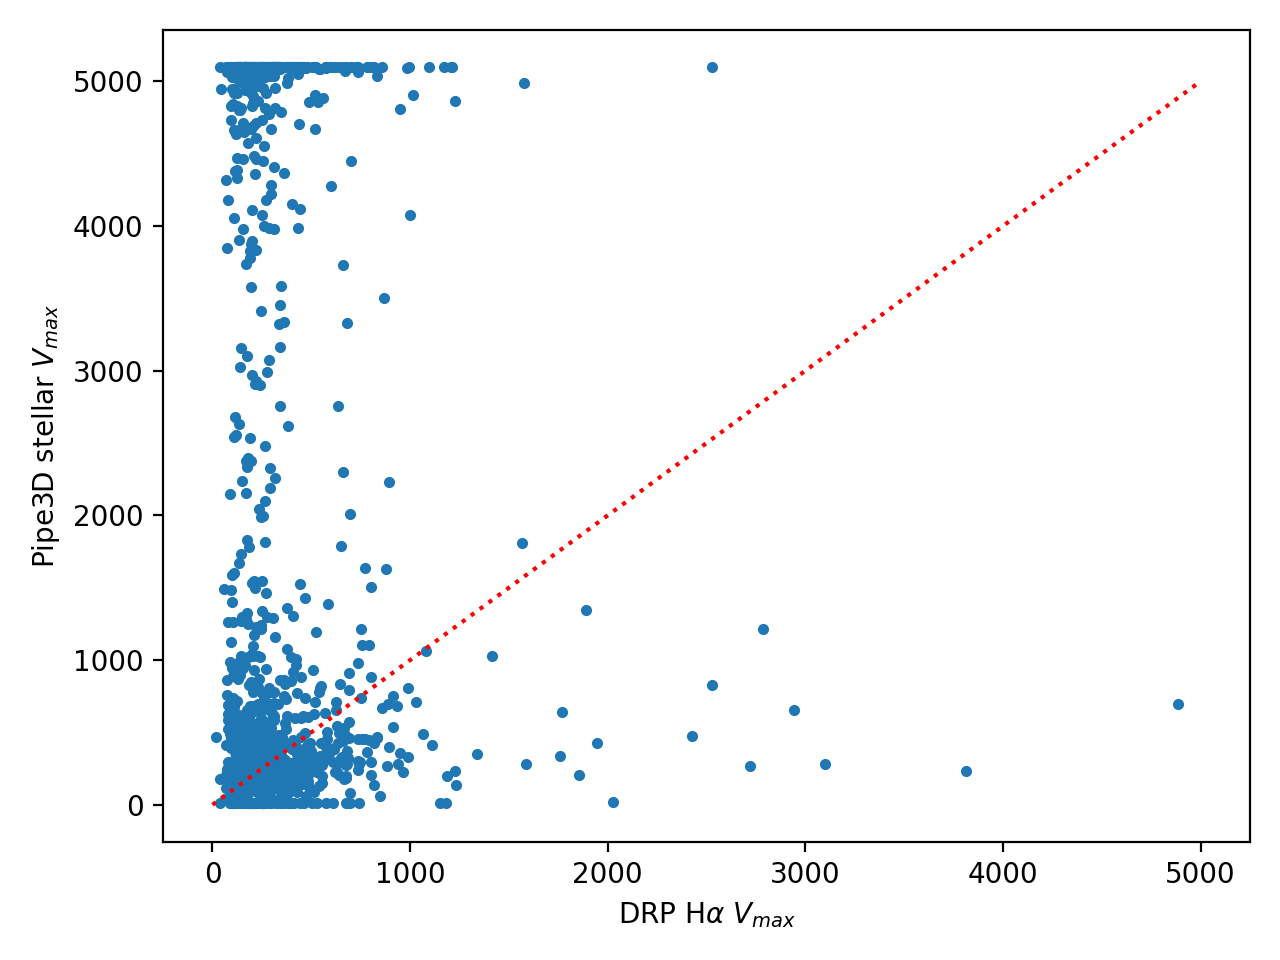

In [32]:
plt.figure(tight_layout=True)

plt.plot(fits['Vmax_map'], fits['v_max_star'], '.')

plt.plot([0,5000], [0,5000], 'r:')

plt.xlabel(r'DRP H$\alpha$ $V_{max}$')
plt.ylabel('Pipe3D stellar $V_{max}$');

<IPython.core.display.Javascript object>


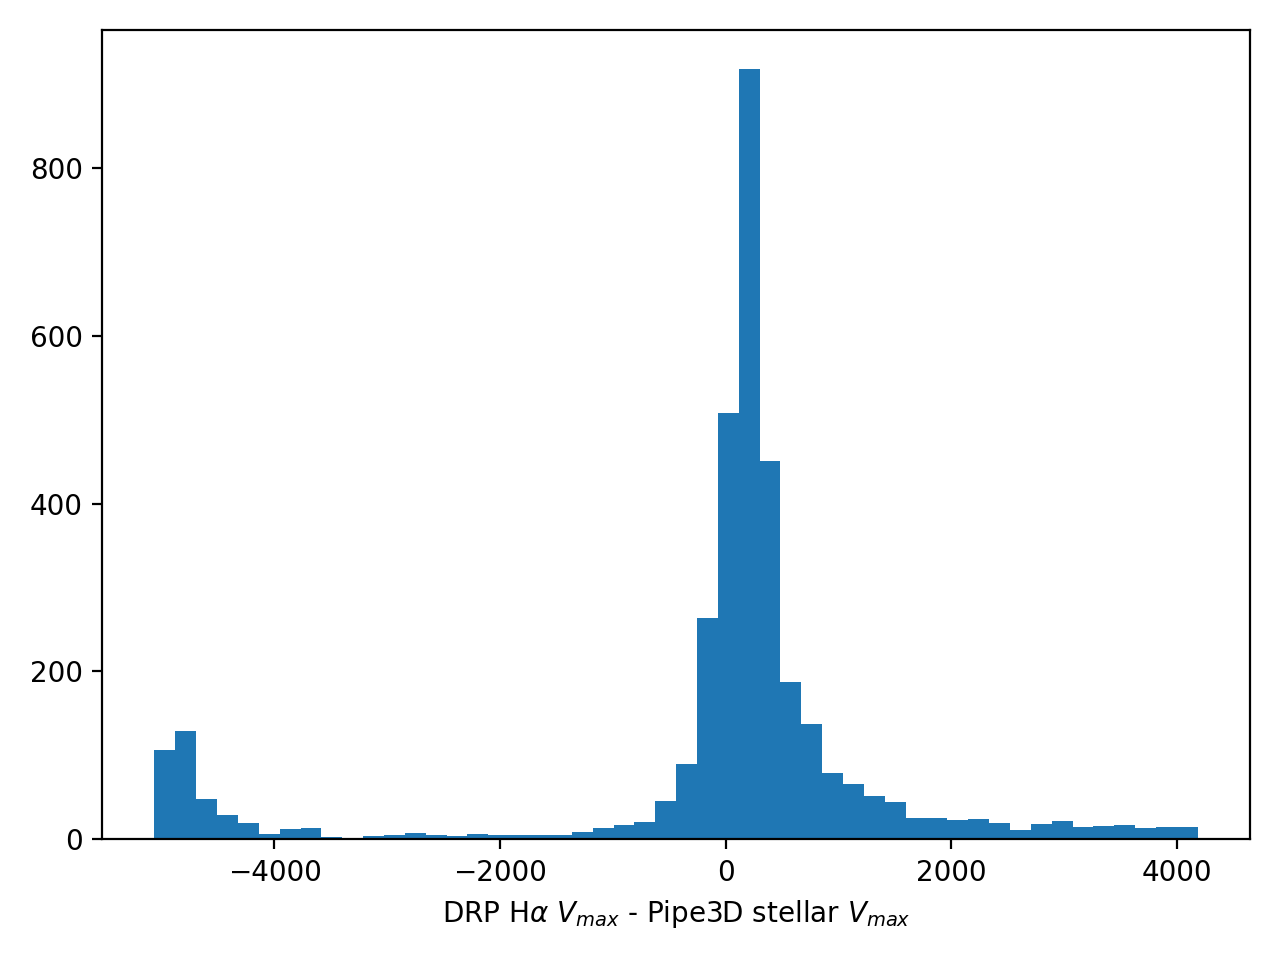

In [35]:
plt.figure(tight_layout=True)

plt.hist(fits['Vmax_map'] - fits['v_max_star'], bins=50)

plt.xlabel(r'DRP H$\alpha$ $V_{max}$ - Pipe3D stellar $V_{max}$');